# DOW Clustering

This notebook aims to perform a clustering analysis regarding customer activity, specifically the number of orders they made throughout the days of the week, their age, and other various factors.

The notebook will be organized as follows:

### 1. Data Preprocessing;

### 2. Hierarchical Clustering

      2.1 Hierarchical Clustering with 4 clusters

      2.2 Hierarchical Clustering with 5 clusters

### 3. K-means Clustering

### 4. Cluster Profile

      4.1 Number of Customers per Cluster

      4.2 City vs Cluster

      4.3 Comparing Clusters with the Entire Dataset

      4.4 Final Cluster Profile

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
sys.path.append('../Functions')
import CleanUp as p

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import DBSCAN


In [2]:
filepath = '../Data/DM2425_ABCDEats_DATASET.csv'
# Load the raw data
raw_data = pd.read_csv(filepath)
df, columns_dict = p.cleanUp(raw_data)

-----------looking for incostisencies -----------
There are repeated values in the dataset
      customer_id customer_region  customer_age  vendor_count  product_count  \
20855  742ca068fc            8550          20.0             1              2   
20907  742ca068fc            8550          20.0             1              2   

       is_chain  first_order  last_order last_promo payment_method  ...  \
20855         0         35.0          35          -           CARD  ...   
20907         0         35.0          35          -           CARD  ...   

       HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
20855      0      0      0      0      0      0      0      0      0      0  
20907      0      0      0      0      0      0      0      0      0      0  

[2 rows x 56 columns]
There are inconsistencies between DOW and HR columns
1553.0
filling HR_0
-----------identify the numerical columns -----------
primary_key is not numerical
-----------Identify the non n

In [3]:
key = columns_dict.keys()
print(key)
new_features_list = columns_dict['new_features_list']
numerical_columns = columns_dict['numerical_columns']
CUI_col = columns_dict['CUI_col']
HR_col = columns_dict['HR_col']
DOW_col = columns_dict['DOW_col']

dict_keys(['non_numerical_columns', 'new_features_list', 'numerical_columns', 'CUI_col', 'HR_col', 'DOW_col'])


In [4]:
df

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,used_promo,order_count,avg_product_by_order,delta_day_order,tot_value_cui,order_freq,value_freq,product_freq,avg_order_value,avg_product_value
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,True,2,2.5,2.0,28.88,1.000000,14.440,2.500000,5.776,5.776
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,True,2,1.0,2.0,19.21,1.000000,9.605,1.000000,9.605,9.605
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,True,2,1.0,2.0,9.20,1.000000,4.600,1.000000,4.600,4.600
3,180c632ed8,4660,26.0,2,3,1,0.0,2,DELIVERY,DIGI,...,True,2,1.5,3.0,31.56,0.666667,10.520,1.000000,10.520,10.520
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,No_Promo,DIGI,...,False,2,2.5,3.0,55.44,0.666667,18.480,1.666667,11.088,11.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,f4e366c281,8670,30.0,1,1,1,0.0,0,FREEBIE,DIGI,...,True,1,1.0,1.0,18.04,1.000000,18.040,1.000000,18.040,18.040
31884,f6b6709018,8670,26.0,1,1,0,0.0,0,DELIVERY,DIGI,...,True,1,1.0,1.0,18.04,1.000000,18.040,1.000000,18.040,18.040
31885,f74ad8ce3f,8670,24.0,1,1,1,0.0,0,No_Promo,DIGI,...,False,1,1.0,1.0,17.79,1.000000,17.790,1.000000,17.790,17.790
31886,f7b19c0241,8670,34.0,1,1,0,0.0,0,DISCOUNT,DIGI,...,True,1,1.0,1.0,12.03,1.000000,12.030,1.000000,12.030,12.030


## 1. Data Processing

In [5]:
# Keep only the columns that are needed for the cluster

fixed_columns = ["customer_city", "customer_age"]

# Combine and select
selected_columns = df[fixed_columns + DOW_col]

cluster_df = df[fixed_columns + DOW_col]

In [6]:
cluster_df

,customer_city,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,2,18.0,1,0,0,0,0,0,1
1,8,17.0,1,0,0,0,0,0,1
2,4,38.0,1,0,0,0,0,0,1
3,4,26.0,0,1,0,0,0,0,1
4,4,20.0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
31883,8,30.0,0,0,0,0,0,0,1
31884,8,26.0,0,0,0,0,0,0,1
31885,8,24.0,0,0,0,0,0,0,1
31886,8,34.0,0,0,0,0,0,0,1


In [7]:
metric_features = ["customer_age", "DOW_0", "DOW_1", "DOW_2", "DOW_3", "DOW_4", "DOW_5", "DOW_6"]
categorical_features = ["customer_city"]

In [8]:
cluster_df.isna().sum()

customer_city    442
customer_age       0
DOW_0              0
DOW_1              0
DOW_2              0
DOW_3              0
DOW_4              0
DOW_5              0
DOW_6              0
dtype: int64

In [9]:
# Scale Age Custom
scaler = MinMaxScaler()
cluster_df["customer_age"] = scaler.fit_transform(cluster_df[["customer_age"]])

C:\Users\andre\AppData\Local\Temp\ipykernel_22176\1331573181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["customer_age"] = scaler.fit_transform(cluster_df[["customer_age"]])


In [10]:
cluster_df

,customer_city,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,2,0.046154,1,0,0,0,0,0,1
1,8,0.030769,1,0,0,0,0,0,1
2,4,0.353846,1,0,0,0,0,0,1
3,4,0.169231,0,1,0,0,0,0,1
4,4,0.076923,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
31883,8,0.230769,0,0,0,0,0,0,1
31884,8,0.169231,0,0,0,0,0,0,1
31885,8,0.138462,0,0,0,0,0,0,1
31886,8,0.292308,0,0,0,0,0,0,1


# 2. Hierarchical Clustering


In [11]:
# Let's wrap them into functions

def get_ss(df, feats):
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()

In [12]:
def get_rsq(df, feats, label_col):
    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        
        
        cluster = AgglomerativeClustering(linkage = link_method, metric = dist, n_clusters = i) # define the cluster
        
        hclabels = cluster.fit_predict(df)  
        
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [13]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([ get_r2_hc(cluster_df[metric_features], # Choose the whole dataframe without the city column
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

In [14]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

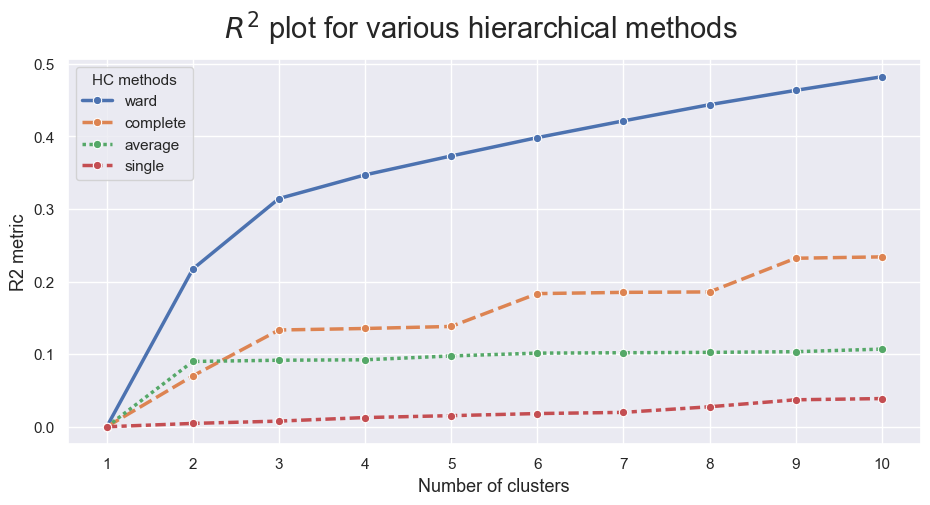

In [15]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

The "ward" method consistently achieves the highest R2 metric. For this method, the R2 metric increases sharply up to 4 clusters, after which the rate of improvement slows down.

Thus, 4 clusters appear to be a good choice. However, it may also be worth exploring the results with 5 clusters for comparison.

In [16]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = "ward" 
distance = "euclidean" 


hclust = AgglomerativeClustering(linkage = linkage, metric=distance, distance_threshold=0, n_clusters=None) # CODE HERE
hclust.fit_predict(cluster_df[metric_features])

array([31731, 31730, 31729, ...,     3,     1,     0], dtype=int64)

In [17]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

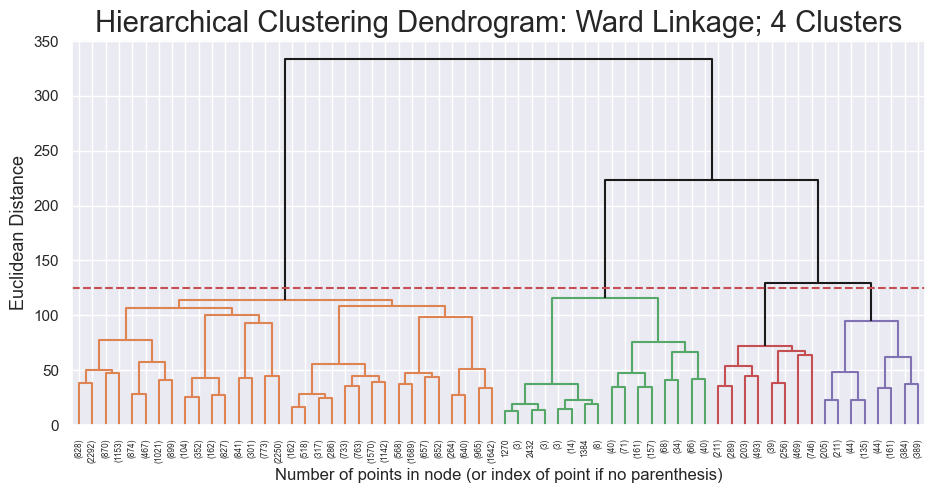

In [18]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 125
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage; 4 Clusters', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

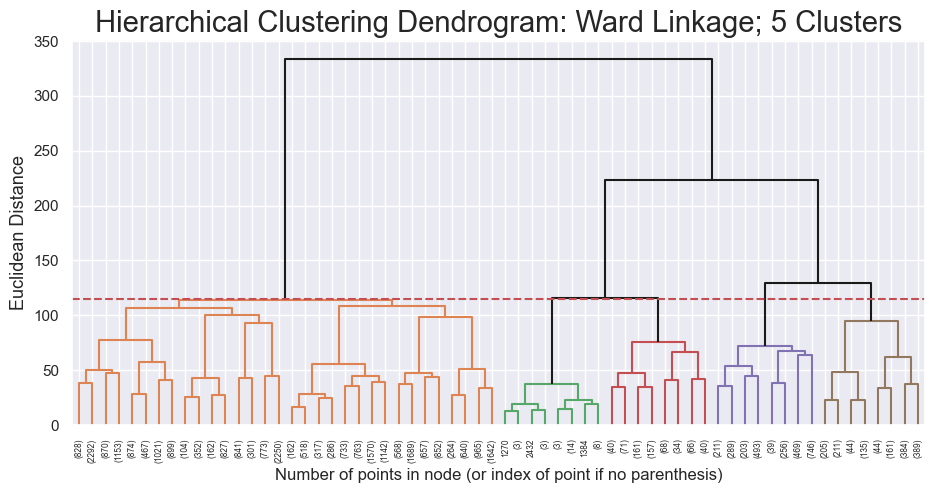

In [19]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 115
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage; 5 Clusters', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### 2.1 HC with 4 clusters

In [20]:
hclust_4 = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc_labels_4 = hclust_4.fit_predict(cluster_df[metric_features])
print(hc_labels_4)

labels_series = pd.Series(hc_labels_4, 
                          name='labels', 
                          index=cluster_df[metric_features].index 
                          ) 

df_concat_4_clusters = pd.concat(
    [cluster_df[metric_features], labels_series],
    axis=1)

df_concat_4_clusters.groupby('labels').mean()

[1 1 1 ... 1 1 1]


,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
labels,,,,,,,,
0,0.190049,3.935917,3.897168,4.086438,3.941878,3.710879,3.500745,4.233979
1,0.191984,0.386752,0.369539,0.395863,0.424203,0.465873,0.417967,0.436487
2,0.188488,0.585505,0.656071,0.626828,0.654164,0.785124,2.586141,2.477432
3,0.193371,1.406504,1.681079,1.668514,1.743163,1.997783,1.184405,1.488174


In [21]:
clustered_numerical_data = df_concat_4_clusters["customer_age"]
clustered_categorical_data = df_concat_4_clusters.drop(columns=["customer_age"])

# Ensure clustered_numerical_data is a DataFrame (2D) before applying inverse_transform
clustered_numerical_data_2d = clustered_numerical_data.values.reshape(-1, 1)

# Perform the inverse transformation
original_numerical_data = scaler.inverse_transform(clustered_numerical_data_2d)

# Convert the result back into a DataFrame for easier manipulation
original_numerical_data = pd.DataFrame(original_numerical_data, columns=["customer_age"])

# Combine with the categorical data
restored_data = pd.concat([original_numerical_data, clustered_categorical_data], axis=1)

restored_data.groupby('labels').mean()

,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
labels,,,,,,,,
0.0,27.926975,3.935917,3.897168,4.086438,3.941878,3.710879,3.500745,4.233979
1.0,27.470856,0.386752,0.369539,0.395863,0.424203,0.465873,0.417967,0.436487
2.0,27.446917,0.585505,0.656071,0.626828,0.654164,0.785124,2.586141,2.477432
3.0,27.311160,1.406504,1.681079,1.668514,1.743163,1.997783,1.184405,1.488174


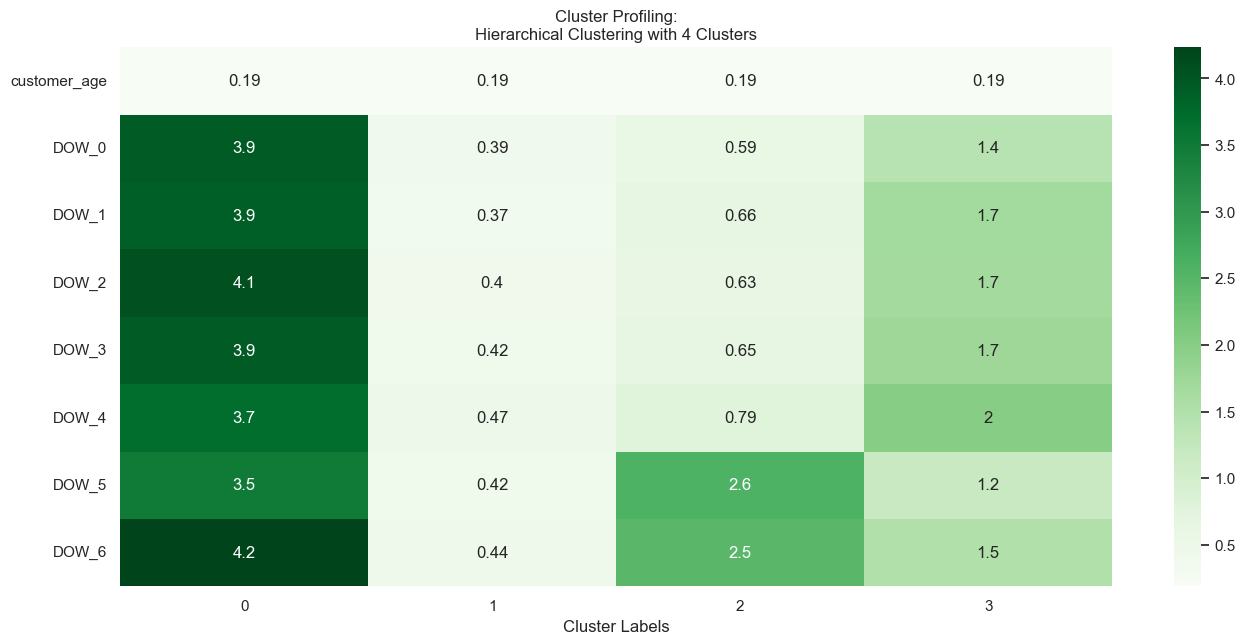

In [22]:
fig, ax = plt.subplots(figsize=(16,7))

hc_profile = df_concat_4_clusters.groupby('labels').mean().T

sns.heatmap(hc_profile,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 4 Clusters")
plt.show()

### 2.2 HC with 5 clusters

In [23]:
hclust_5 = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels_5 = hclust_5.fit_predict(cluster_df[metric_features])
print(hc_labels_5)

labels_series = pd.Series(hc_labels_5, 
                          name='labels', 
                          index=cluster_df[metric_features].index 
                          ) 

df_concat_5_clusters = pd.concat(
    [cluster_df[metric_features], labels_series],
    axis=1)

df_concat_5_clusters.groupby('labels').mean()

[0 0 0 ... 0 0 0]


,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
labels,,,,,,,,
0,0.191984,0.386752,0.369539,0.395863,0.424203,0.465873,0.417967,0.436487
1,0.190388,3.690738,3.582418,3.833595,3.646782,3.398744,3.271586,3.967033
2,0.188488,0.585505,0.656071,0.626828,0.654164,0.785124,2.586141,2.477432
3,0.193371,1.406504,1.681079,1.668514,1.743163,1.997783,1.184405,1.488174
4,0.183710,8.529412,9.794118,8.823529,9.470588,9.558824,7.794118,9.235294


In [24]:
clustered_numerical_data = df_concat_5_clusters["customer_age"]
clustered_categorical_data = df_concat_5_clusters.drop(columns=["customer_age"])

# Ensure clustered_numerical_data is a DataFrame (2D) before applying inverse_transform
clustered_numerical_data_2d = clustered_numerical_data.values.reshape(-1, 1)

# Perform the inverse transformation
original_numerical_data = scaler.inverse_transform(clustered_numerical_data_2d)

# Convert the result back into a DataFrame for easier manipulation
original_numerical_data = pd.DataFrame(original_numerical_data, columns=["customer_age"])

# Combine with the categorical data
restored_data_2 = pd.concat([original_numerical_data, clustered_categorical_data], axis=1)

restored_data_2.groupby('labels').mean()

,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
labels,,,,,,,,
0.0,27.470856,0.386752,0.369539,0.395863,0.424203,0.465873,0.417967,0.436487
1.0,27.916797,3.690738,3.582418,3.833595,3.646782,3.398744,3.271586,3.967033
2.0,27.446917,0.585505,0.656071,0.626828,0.654164,0.785124,2.586141,2.477432
3.0,27.311160,1.406504,1.681079,1.668514,1.743163,1.997783,1.184405,1.488174
4.0,28.117647,8.529412,9.794118,8.823529,9.470588,9.558824,7.794118,9.235294


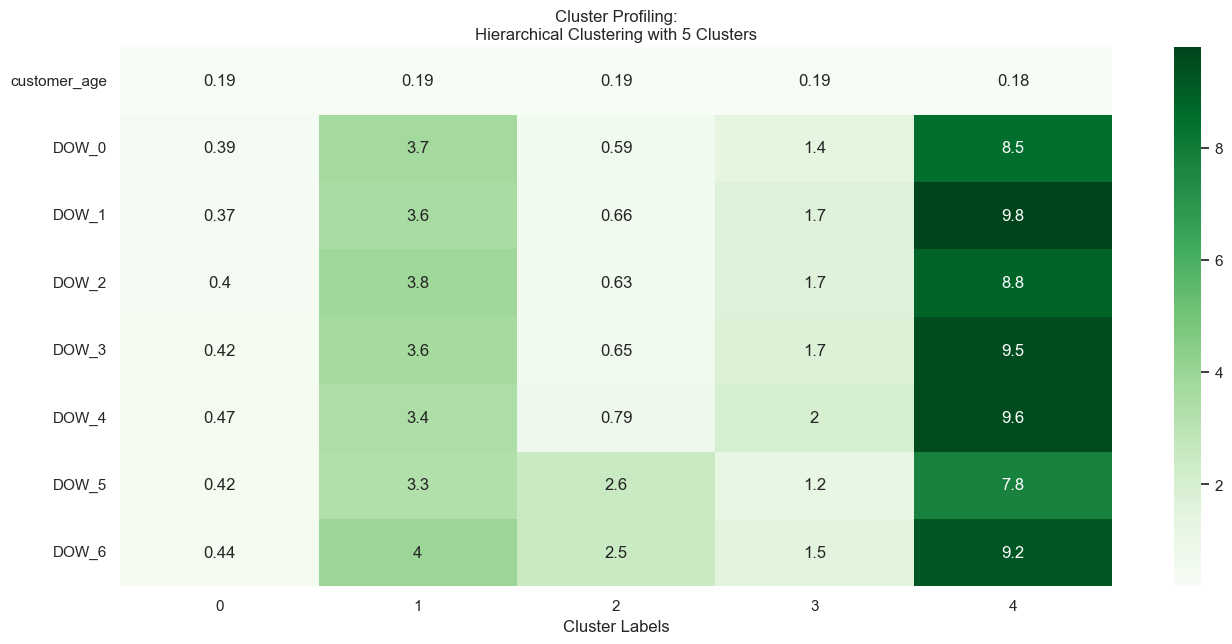

In [25]:
fig, ax = plt.subplots(figsize=(16,7))

hc_profile = df_concat_5_clusters.groupby('labels').mean().T

sns.heatmap(hc_profile,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 5 Clusters")
plt.show()


**Based solely on the heatmaps, the 5-cluster solution appears to be the better choice as it reveals more variation and captures finer distinctions within the data.** 

## 3. K-Means Clustering

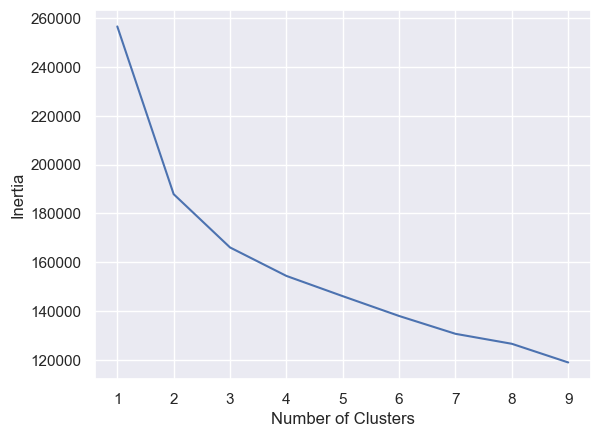

In [26]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k)
    km.fit(cluster_df[metric_features])
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  # Ensure sse and k_rng have the same length here
plt.show()

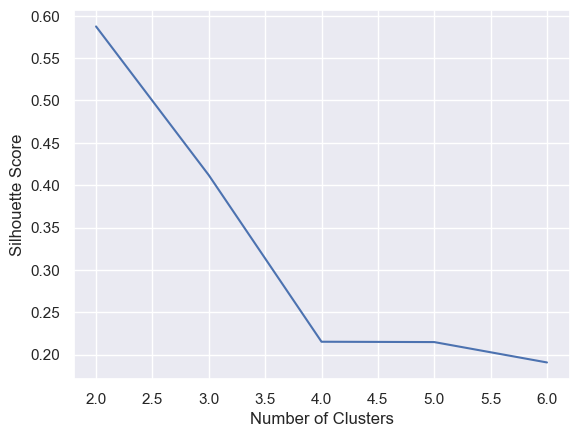

In [27]:
n_clusters = range(2, 7)
s_scores = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(cluster_df[metric_features])
    score = silhouette_score(cluster_df[metric_features], kmeans.labels_)
    s_scores.append(score)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.plot(n_clusters, s_scores)  # Ensure n_clusters and silhouette_scores have the same length here
plt.show()

**Through the elbow graph and the silhouette score we can see that the optimal number of clusters with the k means is 2.**

In [28]:
# Lets use 2 clusters
km = KMeans(n_clusters=2, init="k-means++")

km.fit(cluster_df[metric_features])
k_means_predictions = km.predict(cluster_df[metric_features])

In [29]:
kmeans_cluster_df = cluster_df.copy()
kmeans_cluster_df['predicted_clusters'] = k_means_predictions
kmeans_cluster_df


,customer_city,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,predicted_clusters
0,2,0.046154,1,0,0,0,0,0,1,1
1,8,0.030769,1,0,0,0,0,0,1,1
2,4,0.353846,1,0,0,0,0,0,1,1
3,4,0.169231,0,1,0,0,0,0,1,1
4,4,0.076923,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
31883,8,0.230769,0,0,0,0,0,0,1,1
31884,8,0.169231,0,0,0,0,0,0,1,1
31885,8,0.138462,0,0,0,0,0,0,1,1
31886,8,0.292308,0,0,0,0,0,0,1,1


In [30]:
kmeans_cluster_df[metric_features + ['predicted_clusters']].groupby('predicted_clusters').mean()

,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
predicted_clusters,,,,,,,,
0,0.193373,2.388845,2.482199,2.511867,2.600475,2.604826,2.358782,2.659019
1,0.191759,0.400185,0.404671,0.427852,0.451240,0.514416,0.508595,0.538728


In [31]:
clustered_numerical_data = kmeans_cluster_df["customer_age"]
clustered_categorical_data = kmeans_cluster_df.drop(columns=["customer_age"])

# Ensure clustered_numerical_data is a DataFrame (2D) before applying inverse_transform
clustered_numerical_data_2d = clustered_numerical_data.values.reshape(-1, 1)

# Perform the inverse transformation
original_numerical_data = scaler.inverse_transform(clustered_numerical_data_2d)

# Convert the result back into a DataFrame for easier manipulation
original_numerical_data2 = pd.DataFrame(original_numerical_data, columns=["customer_age"])

# Reset index for both DataFrames to ensure they align
original_numerical_data2.reset_index(drop=True, inplace=True)
clustered_categorical_data.reset_index(drop=True, inplace=True)

# Now you can concatenate
restored_data2 = pd.concat([original_numerical_data2, clustered_categorical_data], axis=1)

In [32]:
restored_data2[metric_features + ['predicted_clusters']].groupby('predicted_clusters').mean()

,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
predicted_clusters,,,,,,,,
0,27.569225,2.388845,2.482199,2.511867,2.600475,2.604826,2.358782,2.659019
1,27.464354,0.400185,0.404671,0.427852,0.451240,0.514416,0.508595,0.538728


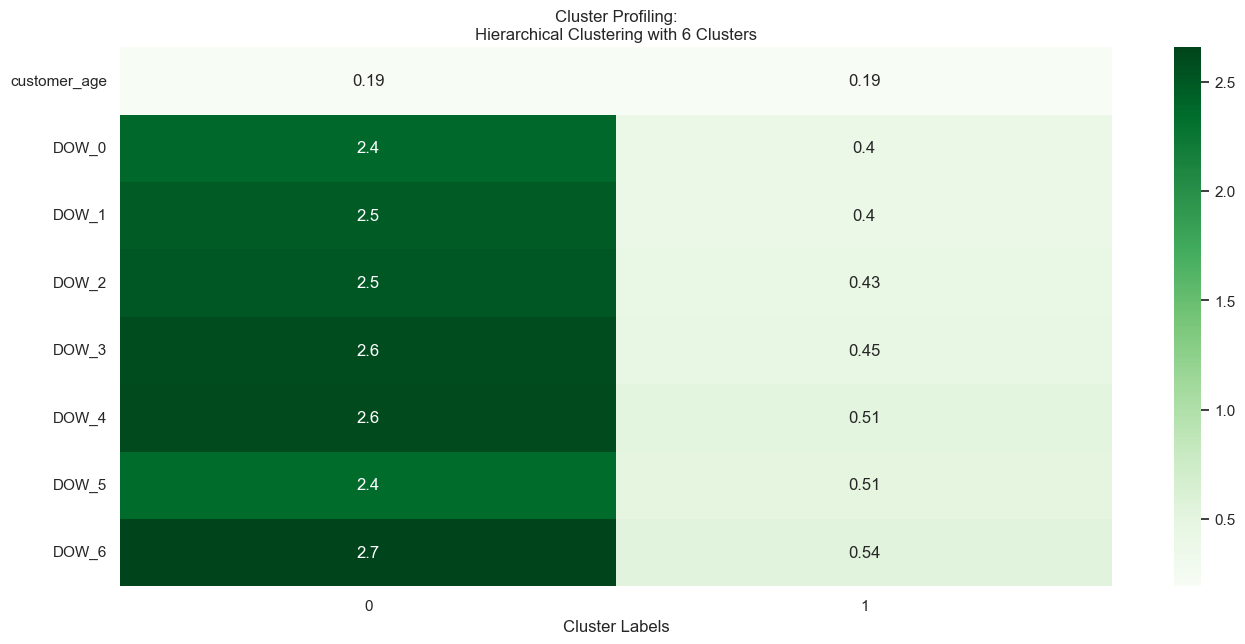

In [33]:
fig, ax = plt.subplots(figsize=(16,7))

sns.heatmap(kmeans_cluster_df[metric_features + ['predicted_clusters']].groupby('predicted_clusters').mean().T,
            ax=ax,
            cmap='Greens',
            annot = True
            ) 

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 6 Clusters")
plt.show()

### Conclusions

**Although the silhouette score analysis using k-means indicates that the optimal number of clusters is 2—suggesting that our dataset has two well-separated clusters—in, my point of view, the hierarchical clustering with 4 clusters highlights the existence of subgroups within these two main clusters. These subgroups exhibit distinct purchasing behaviors, which makes them a more suitable choice for the next stage of analysis. I choose the 4 clusters instead of the 5, because with the 5 clusters there are an additional cluster that only has 0.1% of the population, what is very irrevelant.**

## 4. Cluster Profiling

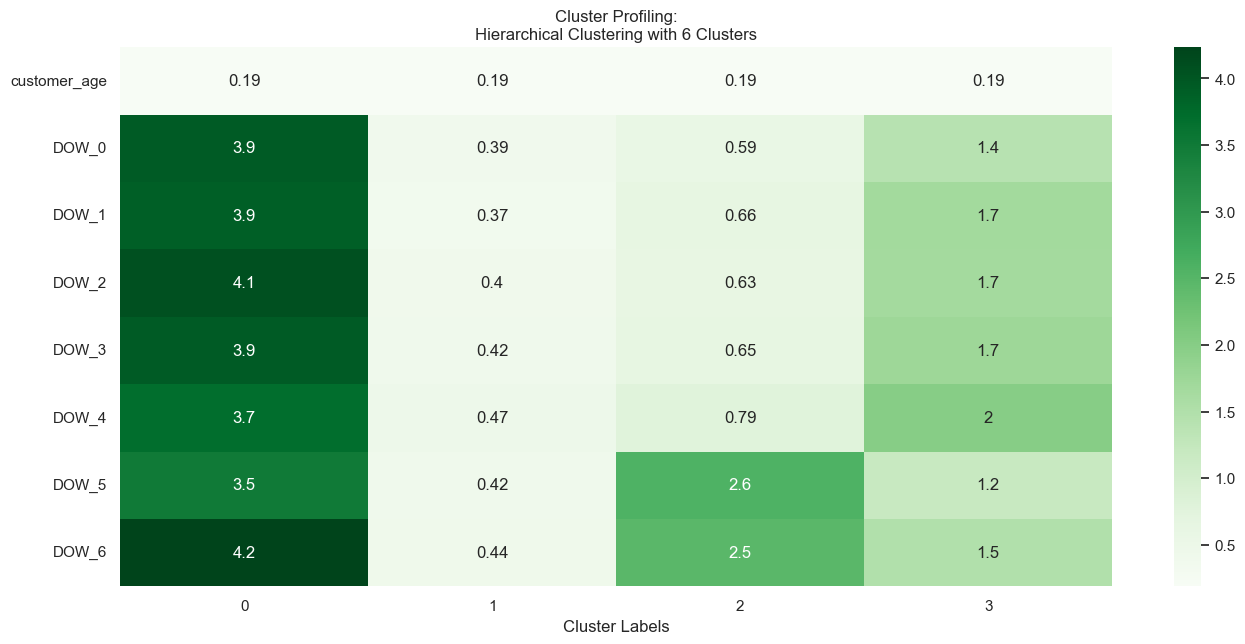

### 1. **Customer Age**
- The normalized mean age is consistent across all clusters (**0.19** normalized value).  
  This suggests that **age does not significantly influence the clustering**.

---

### 2. **Purchasing Patterns Throughout the Days of the Week**

#### **Cluster 0**
- **Activity:** The highest activity levels across all days, with particularly high values on:
  - **DOW_2 (Tuesday): 4.1**
  - **DOW_6 (Saturday): 4.2**
- **Conclusion:** Represents **very high-frequency customers**, with **consistent activity throughout the week**.

#### **Cluster 1**
- **Activity:** Lowest activity among all clusters, with a relatively uniform spread across all days, increasing in the end of the week.
- **Conclusion:** Represents **less active but consistent customers**.

#### **Cluster 2**
- **Activity:** Moderate to high activity levels, with peaks on:
  - **DOW_5 (Friday): 2.6**
  - **DOW_6 (Saturday): 2.5**
- **Conclusion:** Represents customers who **regularly purchase during the midweek** and have a noticeable **peak on Fridays and Saturdays**.

#### **Cluster 3**
- **Activity:** High uniform activity spread across all days, with a **slightly higher activity during the midweek.** 
- **Conclusion:** Represents **moderately active and consistent customers**.



### 4.1 Number of Customers per Cluster

In [34]:
cluster_df["Clusters"] = df_concat_4_clusters["labels"]
cluster_df

C:\Users\andre\AppData\Local\Temp\ipykernel_22176\3269297268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["Clusters"] = df_concat_4_clusters["labels"]


,customer_city,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Clusters
0,2,0.046154,1,0,0,0,0,0,1,1
1,8,0.030769,1,0,0,0,0,0,1,1
2,4,0.353846,1,0,0,0,0,0,1,1
3,4,0.169231,0,1,0,0,0,0,1,1
4,4,0.076923,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
31883,8,0.230769,0,0,0,0,0,0,1,1
31884,8,0.169231,0,0,0,0,0,0,1,1
31885,8,0.138462,0,0,0,0,0,0,1,1
31886,8,0.292308,0,0,0,0,0,0,1,1


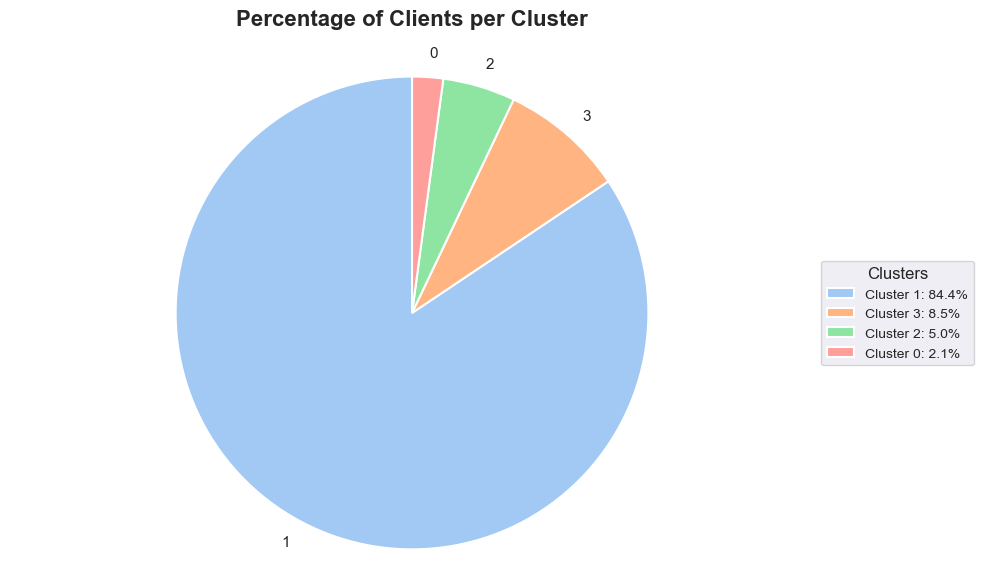

In [35]:
# Count the number of rows for each cluster
cluster_counts = cluster_df['Clusters'].value_counts()

# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the pie chart without percentages
wedges, texts = ax.pie(
    cluster_counts, 
    labels=[f"{i}" for i in cluster_counts.index],  # Cluster labels
    startangle=90, 
    colors=sns.color_palette("pastel"),  # Pastel colors for a clean look
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}  # Add edge for clarity
)

# Create a legend with only percentages
cluster_percentages = [f"Cluster {i}: {count / cluster_counts.sum() * 100:.1f}%" 
                       for i, count in zip(cluster_counts.index, cluster_counts)]

# Add the legend outside the pie chart
ax.legend(
    labels=cluster_percentages, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    title="Clusters", 
    title_fontsize=12, 
    fontsize=10
)

# Add a title with better styling
plt.title('Percentage of Clients per Cluster', fontsize=16, weight='bold', pad=20)

# Ensure the pie chart is a circle
ax.axis('equal')

# Optimize layout
plt.tight_layout()
plt.show()


**We can observe that the majority of customers belong to cluster 1.**

### 4.2 City vs Clusters

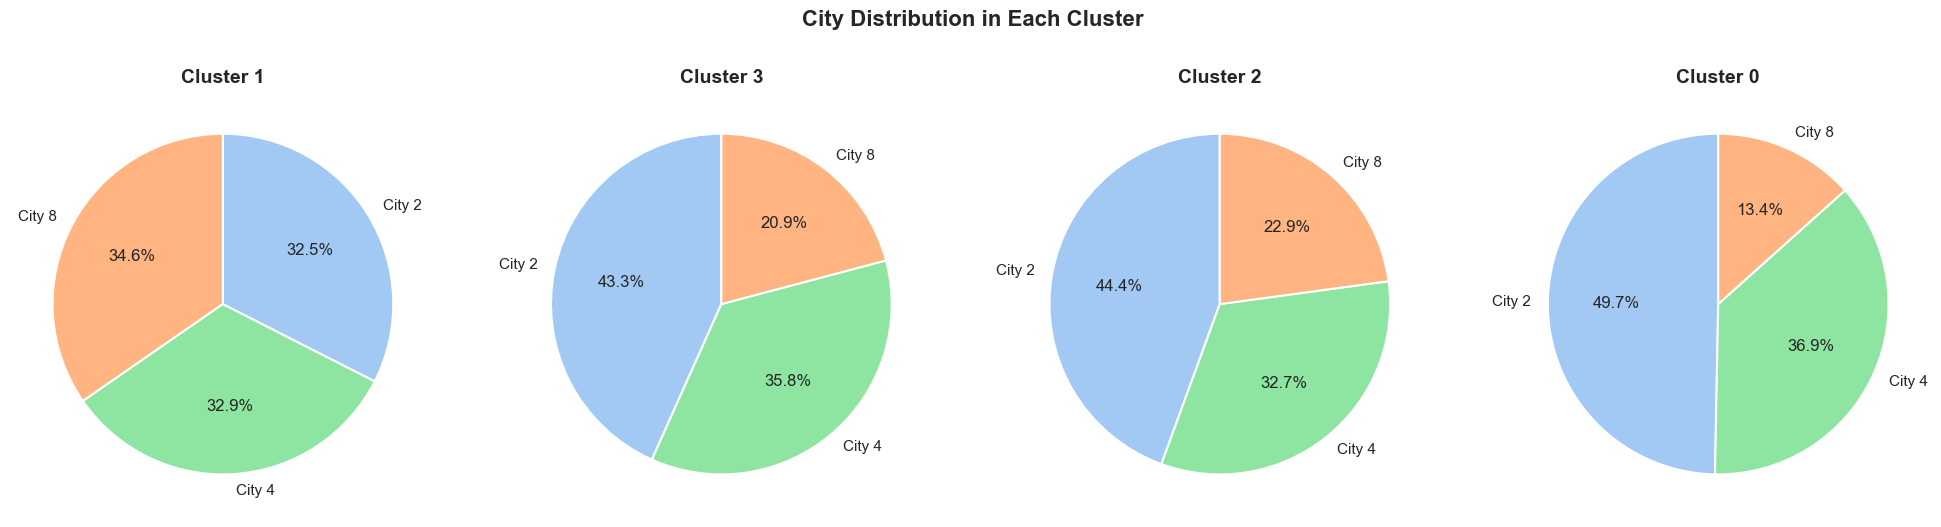

In [36]:
# Obter todas as cidades únicas e clusters únicos
unique_cities = cluster_df['customer_city'].unique()
unique_clusters = cluster_df['Clusters'].unique()

# Criar um mapa fixo de cores para cada cidade
color_palette = sns.color_palette("pastel", len(unique_cities))
city_color_map = {city: color_palette[i] for i, city in enumerate(unique_cities)}

# Criar a figura e os eixos
fig, axes = plt.subplots(1, len(unique_clusters), figsize=(20, 5))

# Gerar os gráficos de pizza para cada cluster
for i, cluster in enumerate(unique_clusters):
    # Filtrar os dados para o cluster atual e contar as cidades
    cluster_data = cluster_df[cluster_df['Clusters'] == cluster]['customer_city'].value_counts()
    
    # Criar uma lista de cores com base nas cidades do cluster
    colors = [city_color_map[city] for city in cluster_data.index]
    
    # Plotar o gráfico de pizza
    axes[i].pie(
        cluster_data, 
        labels=[f"City {city}" for city in cluster_data.index], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    axes[i].set_title(f'Cluster {cluster}', fontsize=14, weight='bold')

# Título principal e ajuste de layout
plt.suptitle('City Distribution in Each Cluster', fontsize=16, weight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 4.3 Comparing Clusters with The Entire DataSet

In [37]:
merged_df = pd.merge(df_concat_4_clusters[DOW_col + ['labels']], df[new_features_list], left_index=True, right_index=True)
merged_df

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,labels,customer_city,used_promo,order_count,avg_product_by_order,delta_day_order,tot_value_cui,order_freq,value_freq,product_freq,avg_order_value,avg_product_value
0,1,0,0,0,0,0,1,1,2,True,2,2.5,2.0,28.88,1.000000,14.440,2.500000,5.776,5.776
1,1,0,0,0,0,0,1,1,8,True,2,1.0,2.0,19.21,1.000000,9.605,1.000000,9.605,9.605
2,1,0,0,0,0,0,1,1,4,True,2,1.0,2.0,9.20,1.000000,4.600,1.000000,4.600,4.600
3,0,1,0,0,0,0,1,1,4,True,2,1.5,3.0,31.56,0.666667,10.520,1.000000,10.520,10.520
4,0,1,0,0,0,0,1,1,4,False,2,2.5,3.0,55.44,0.666667,18.480,1.666667,11.088,11.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,0,0,0,0,0,0,1,1,8,True,1,1.0,1.0,18.04,1.000000,18.040,1.000000,18.040,18.040
31884,0,0,0,0,0,0,1,1,8,True,1,1.0,1.0,18.04,1.000000,18.040,1.000000,18.040,18.040
31885,0,0,0,0,0,0,1,1,8,False,1,1.0,1.0,17.79,1.000000,17.790,1.000000,17.790,17.790
31886,0,0,0,0,0,0,1,1,8,True,1,1.0,1.0,12.03,1.000000,12.030,1.000000,12.030,12.030


In [38]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to be normalized (excluding non-numerical columns)
columns_to_normalize = remaining_columns = merged_df.drop(columns=["labels"]).columns

# Apply the scaler to the selected columns
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

# Display the normalized dataframe
merged_df.head()

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,labels,customer_city,used_promo,order_count,avg_product_by_order,delta_day_order,tot_value_cui,order_freq,value_freq,product_freq,avg_order_value,avg_product_value
0,0.0625,0.000000,0.0,0.0,0.0,0.0,0.05,1,0.000000,1.0,0.010753,0.3,0.011111,0.020106,0.245810,0.102119,0.177251,0.225062,0.225062
1,0.0625,0.000000,0.0,0.0,0.0,0.0,0.05,1,1.000000,1.0,0.010753,0.0,0.011111,0.013287,0.245810,0.067849,0.069936,0.384471,0.384471
2,0.0625,0.000000,0.0,0.0,0.0,0.0,0.05,1,0.333333,1.0,0.010753,0.0,0.011111,0.006227,0.245810,0.032375,0.069936,0.176103,0.176103
3,0.0000,0.058824,0.0,0.0,0.0,0.0,0.05,1,0.333333,1.0,0.010753,0.1,0.022222,0.021996,0.162011,0.074334,0.069936,0.422565,0.422565
4,0.0000,0.058824,0.0,0.0,0.0,0.0,0.05,1,0.333333,0.0,0.010753,0.3,0.022222,0.038837,0.162011,0.130753,0.117631,0.446211,0.446211


In [39]:
group_means = merged_df.groupby('labels').mean().T

# Calculate the overall mean of the DataFrame (excluding the 'labels' column)
overall_mean = pd.DataFrame(merged_df.drop(columns='labels').mean()) # Transpose to match the shape for concatenation

# Concatenate the two DataFrames horizontally
result = pd.concat([group_means, overall_mean], axis=1)
result.columns = list(result.columns[:-1]) + ['Overall Mean']

result = result.drop(index='customer_city')

result

,0,1,2,3,Overall Mean
DOW_0,0.245995,0.024172,0.036594,0.087907,0.034913
DOW_1,0.229245,0.021738,0.038592,0.098887,0.033540
DOW_2,0.272429,0.026391,0.041789,0.111234,0.039592
DOW_3,0.231875,0.024953,0.038480,0.102539,0.036615
DOW_4,0.231930,0.029117,0.049070,0.124861,0.042560
DOW_5,0.175037,0.020898,0.129307,0.059220,0.032800
DOW_6,0.211699,0.021824,0.123872,0.074409,0.035382
used_promo,0.321908,0.495482,0.366815,0.360680,0.473938
order_count,0.282871,0.020394,0.079261,0.109351,0.036449
avg_product_by_order,0.063019,0.059504,0.064141,0.061062,0.059941


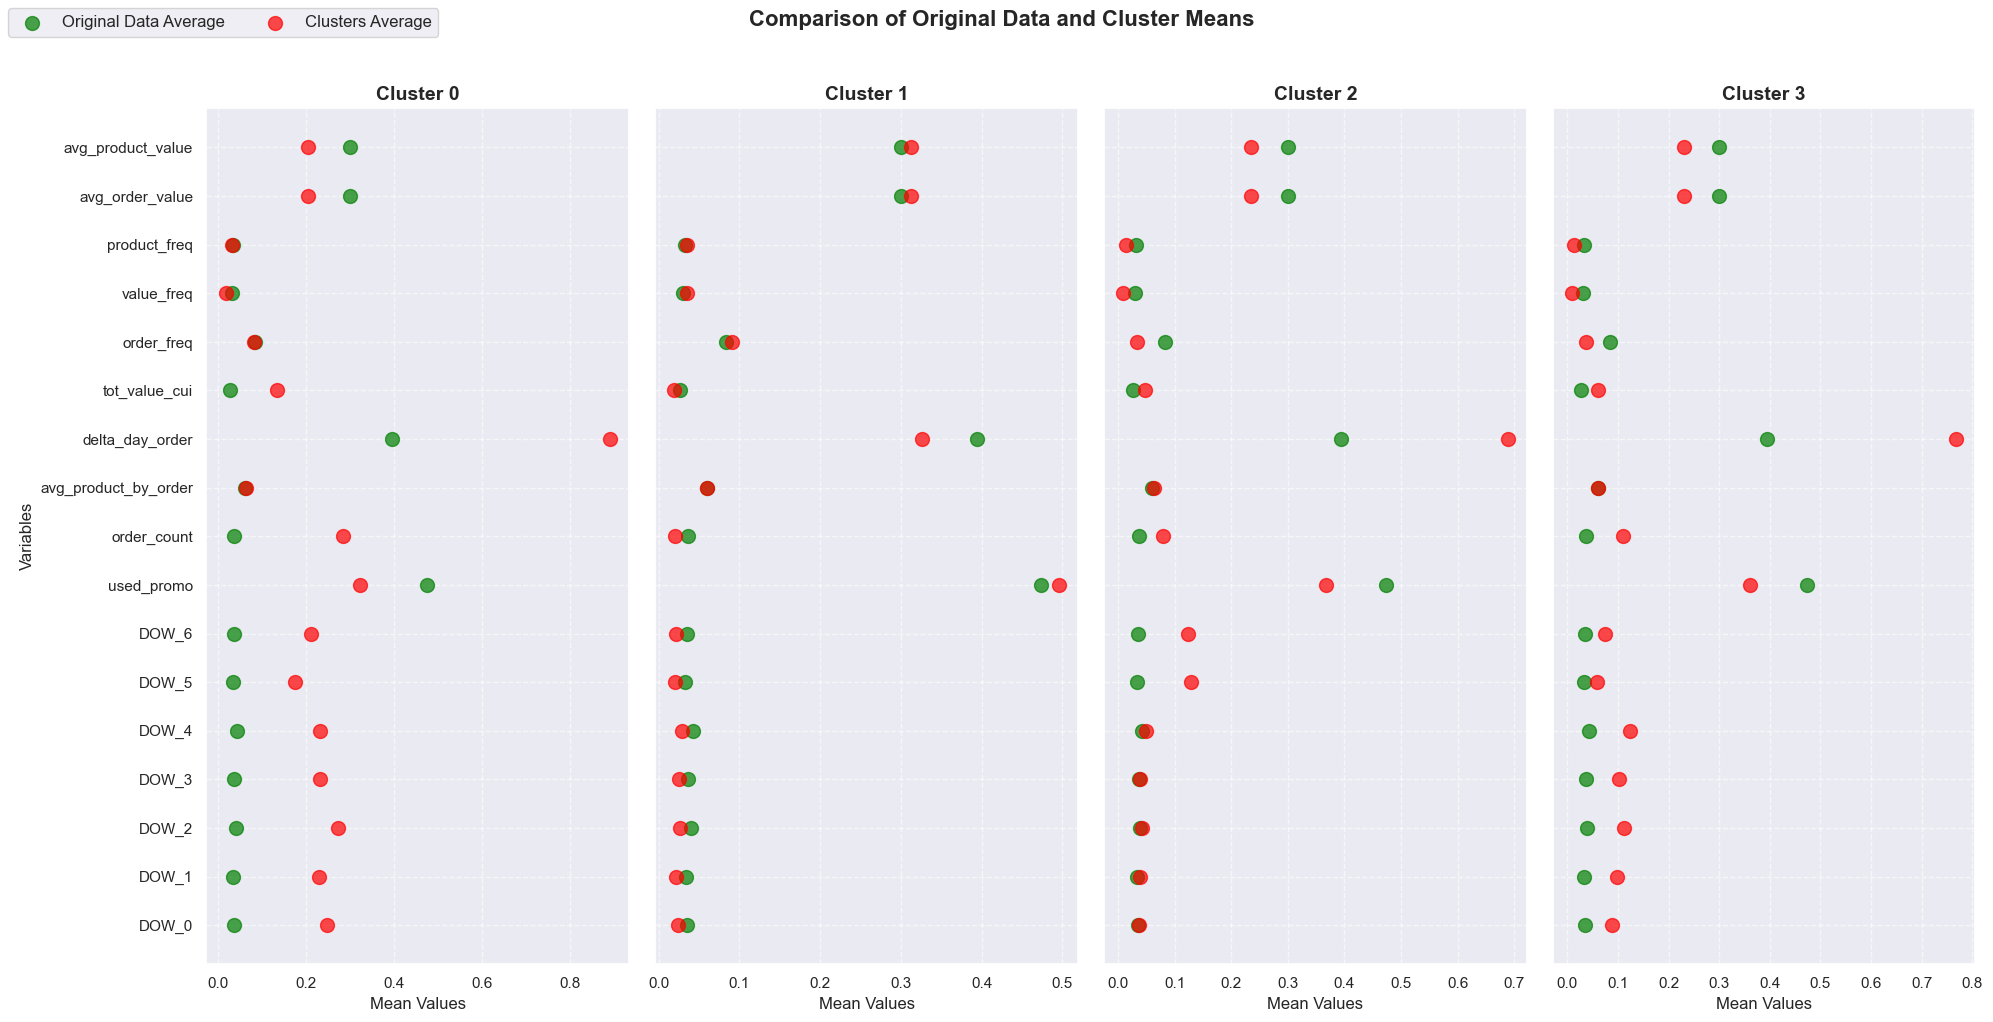

In [40]:
original_data_means = result['Overall Mean']
cluster_means = {
    0: result[0],
    1: result[1],
    2: result[2],
    3: result[3]
}

# Variables (replace with your variable names)
variables = result.index.to_list()

# Plotting
fig, axes = plt.subplots(1, len(cluster_means), figsize=(20, 10), sharey=True)

for cluster, ax in zip(cluster_means.keys(), axes):
    # Scatter plot for the database means
    ax.scatter(original_data_means, variables, color='green', label='Original Data Average', s=100, alpha=0.7)
    
    # Scatter plot for the cluster means
    ax.scatter(cluster_means[cluster], variables, color='red', label=f'Clusters Average', s=100, alpha=0.7)
    
    # Titles and labels
    ax.set_title(f'Cluster {cluster}', fontsize=14, weight='bold')
    ax.set_xlabel('Mean Values', fontsize=12)
    if cluster == 0:
        ax.set_ylabel('Variables', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Add a shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=12)  # Change the location here

# Add a main title
fig.suptitle('Comparison of Original Data and Cluster Means', fontsize=16, weight='bold', y=1.02)

plt.tight_layout()
plt.show()

### 4.4 Final Cluster Profile

| Cluster | Key Characteristics | Potential Marketing Strategy |
|---|---|---|
| **Cluster 0: High-Frequency Shoppers (2.1%)** | Very high purchase frequency throughout the week; In addition to that on average have a higher fidelity (delta day order) than the rest of the clients| Loyalty programs with exclusive rewards  (They use less promotions); Personalized recommendations based on past purchases; Targeted promotions for off-peak days to encourage diversification |
| **Cluster 1: The Majority (84.4%)** | Largest cluster with the lowest activity, representing 84.4% of the clients; Consistent purchasing behavior | Retention-focused strategies to maintain loyalty; Personalized offers and discounts; Targeted email campaigns highlighting new products and promotions |
| **Cluster 2: The Weekend Shoopers (5.0%)** | Moderate to high activity levels, with peaks on Fridays and Saturdays; Less active during the midweek. Furthermore, like cluster 0, these customers have, on average, a higher loyalty rate (delta day order) than the average of all customers. | Weekend-specific promotions and discounts; Partnerships with complementary businesses for cross-promotions; Email campaigns highlighting weekend deals and new arrivals |
| **Cluster 3: The Midweek Shoppers (8.5%)** | High uniform activity spread across all days, with a slightly higher activity during the midweek | Midweek promotions and discounts; Loyalty programs with tiered rewards for midweek purchases; Personalized email campaigns featuring curated product selections |

### Age as a Factor

Interestingly, the analysis suggests that age does not significantly influence the clustering. This indicates that purchasing patterns are more strongly driven by other factors, such as 

lifestyle, preferences, and habits.

### City as a Factor

We can see that city 2 has the greatest impact on the number of orders placed by customers. The clusters with the lowest activity, namely 1, is the one that have a more uniform 

distribution of the population across the three cities. As the population from city 2 increases in percentage relative to the others, we observe an increase in activity, which suggests 

that the residents of this city are the most active customers.